In [102]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing as fch

import seaborn as sns
 
from matplotlib import pyplot as plt
 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

from sklearn.cluster import KMeans


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую).
Проверьте данные на наличие пропусков. Удалите их в случае обнаружения.


In [103]:
# Пропуски в данных не обнаружены.

In [104]:
california_housing = fch(as_frame=True).frame

In [105]:
# housing_names = fch(as_frame=True).feature_names   # Вначале в качестве списка столбцов использовал feature_names, потом это стало неактуальным вследствие добавления новых столбцов

In [106]:
# Функции нормализации значений по минимаксу и для z-масштабирования (реализовал как функции, хотя можно использовать StandardScaler)

def normalize (dt, strg, dt_min, dt_max):
  return (dt[strg] - dt_min) / (dt_max - dt_min)
  
def z_scale(dt, strg, dt_mean, dt_stdev):
  return (dt[strg] - dt_mean) / dt_stdev

In [107]:
california_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [108]:
housing_names = ['MedInc', 'HouseAge','AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Bedrooms_per_Room', 'Total_Avg_Rooms', 'Population_per_Room'] # - список столбцов

Посчитайте и выведите корреляционную матрицу. Убедитесь, что ячейки матрицы поделены на цветные категории, в ячейках указано числовое значение корреляции.

a. Сделайте выводы.

b. Удалите признаки на основании полученных значений, выводов.

c. Повторите п. 3, п. 4 на измененных данных.

In [109]:
california_housing.corr().style.background_gradient(cmap='coolwarm')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


In [110]:
# Выводы по корреляционной матрице:
# 1) Существует сильная прямая линейная корреляция между средним уровнем дохода и ценой дома
# 2) Слабая прямая линейная корреляция между ценой дома и: возрастом дома, количеством комнат
# 3) При попытке удалить признаки, вроде бы не имеющие сильной корреляции почему-то происходило достаточно сильное снижение эффективности обучения модели линейной регрессии (на несколько процентов, в ряде случаев - до 10 и более %)

In [111]:
# Дополнительные признаки, полученные в результате эффектов взаимодействия (новые признаки из имеющихся данных):

california_housing['Bedrooms_per_Room'] = california_housing['AveBedrms'] / california_housing['AveRooms']  # - количество спален на каждую комнату
california_housing['Total_Avg_Rooms'] = california_housing['AveRooms'] + california_housing['AveBedrms'] # - сумма всех комнат (спальни + другие комнаты)
california_housing['Population_per_Room'] = california_housing['Population'] / california_housing['Total_Avg_Rooms'] # - среднее кол-во человек на каждую комнату

In [112]:
california_housing.corr().style.background_gradient(cmap='coolwarm') # - корреляционная матрица с новыми столбцами: определилась слабая обратная зависимость между ценой дома и Bedrooms_per_Room и слабая прямая зависимость между ценой дома и Total_Avg_Rooms

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,Bedrooms_per_Room,Total_Avg_Rooms,Population_per_Room
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075,-0.615479,0.269982,-0.147857
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623,0.136367,-0.144130,-0.212669
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948,-0.418704,0.996199,-0.204547
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701,0.055817,0.890618,-0.086387
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650,0.037075,-0.072757,0.940511
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737,0.002881,-0.005173,0.079868
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160,-0.114302,0.102626,-0.138710
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967,0.092868,-0.021413,0.114704
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000,-0.255624,0.122561,-0.082464
Bedrooms_per_Room,-0.615479,0.136367,-0.418704,0.055817,0.037075,0.002881,-0.114302,0.092868,-0.255624,1.000000,-0.349688,0.274527


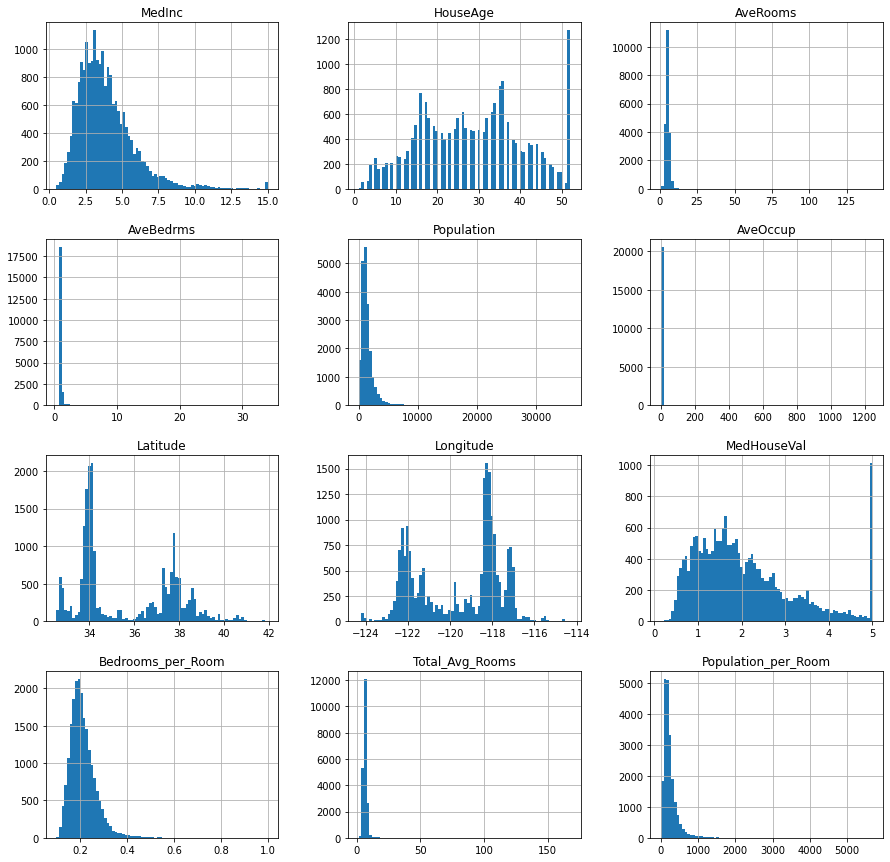

In [113]:
california_housing.hist(bins=80, figsize=(15,15))  # - графики распределения всех переменных
plt.show()

<AxesSubplot:xlabel='Широта', ylabel='Долгота'>

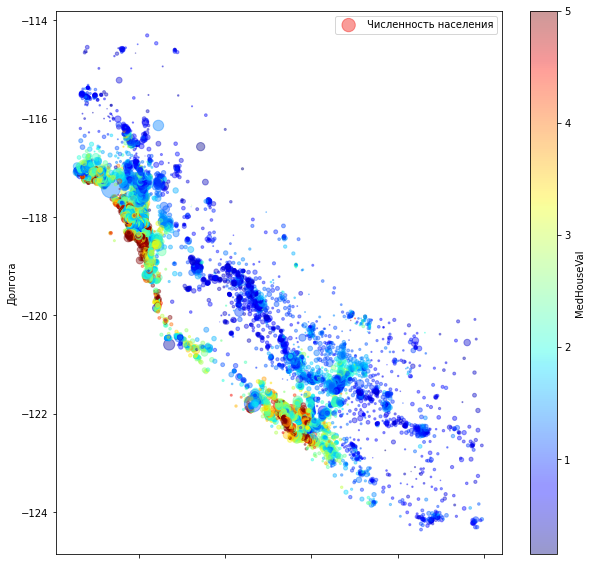

In [114]:
california_housing.plot(kind='scatter', x='Latitude', y='Longitude', s=california_housing['Population'] / 100, c='MedHouseVal', alpha=0.4, label='Численность населения', figsize=(10,10), cmap=plt.get_cmap('jet'), colorbar=True, xlabel='Широта', ylabel='Долгота')

In [115]:
# Создание новых столбцов с использованием функций, написанных выше - минимакс нормализация, z-масштабирование, и извлечение логарифма (затем удалил преобразованные столбцы широты и долготы, т.к. их преобразовывать считаю нецелесообразным)

for name_ in housing_names:
  california_housing[name_ + '_norm'] = california_housing.apply(normalize, strg=name_, dt_min = california_housing[name_].min(),  dt_max = california_housing[name_].max(), axis=1)
  california_housing[name_ + '_z_scale'] = california_housing.apply(z_scale, strg=name_, dt_mean = california_housing[name_].mean(),  dt_stdev = california_housing[name_].std(), axis=1)
  california_housing[name_ + '_log'] = california_housing[name_].apply(lambda x: np.log(x))
california_housing['MedInc_category'] = pd.qcut(california_housing['MedInc'], 4, labels=[0,1,2,3])
california_housing.drop(['Latitude_norm', 'Longitude_norm', 'Latitude_z_scale', 'Longitude_z_scale', 'Latitude_log', 'Longitude_log'], axis=1, inplace=True)



In [116]:
km = KMeans(n_clusters = 25)
cluster = km.fit_predict(california_housing[['Latitude', 'Longitude']])

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [117]:
california_housing['Region_cluster'] = cluster 

In [118]:
california_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,Bedrooms_per_Room,Total_Avg_Rooms,Population_per_Room,MedInc_norm,MedInc_z_scale,MedInc_log,HouseAge_norm,HouseAge_z_scale,HouseAge_log,AveRooms_norm,AveRooms_z_scale,AveRooms_log,AveBedrms_norm,AveBedrms_z_scale,AveBedrms_log,Population_norm,Population_z_scale,Population_log,AveOccup_norm,AveOccup_z_scale,AveOccup_log,Bedrooms_per_Room_norm,Bedrooms_per_Room_z_scale,Bedrooms_per_Room_log,Total_Avg_Rooms_norm,Total_Avg_Rooms_z_scale,Total_Avg_Rooms_log,Population_per_Room_norm,Population_per_Room_z_scale,Population_per_Room_log,MedInc_category,Region_cluster
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0.146591,8.007937,40.210109,0.539668,2.344709,2.119287,0.784314,0.982119,3.713572,0.043512,0.628544,1.943640,0.020469,-0.153754,0.023530,0.008941,-0.974405,5.774552,0.001499,-0.049595,0.938270,0.051768,-1.145805,-1.920110,0.039836,0.513454,2.080433,0.007047,-0.998952,3.694118,3,7
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0.155797,7.210018,333.008897,0.538027,2.332181,2.116424,0.392157,-0.607004,3.044522,0.038224,0.327033,1.830682,0.018929,-0.263329,-0.028522,0.067210,0.861418,7.783641,0.001141,-0.092510,0.746613,0.061996,-0.987151,-1.859204,0.035034,0.237056,1.975471,0.058589,0.504426,5.808169,3,7
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,0.129516,9.361582,52.982498,0.466028,1.782656,1.982022,1.000000,1.856137,3.951244,0.052756,1.155592,2.114825,0.021940,-0.049015,0.070874,0.013818,-0.820757,6.206576,0.001698,-0.025842,1.030426,0.032796,-1.440081,-2.043951,0.047983,0.982356,2.236614,0.009295,-0.933372,3.969962,3,7
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0.184458,6.890411,80.982107,0.354699,0.932945,1.730434,1.000000,1.856137,3.951244,0.035241,0.156962,1.760845,0.021929,-0.049832,0.070514,0.015555,-0.766010,6.324359,0.001493,-0.050328,0.935287,0.093843,-0.493182,-1.690331,0.033110,0.126344,1.930131,0.014224,-0.789608,4.394228,3,7
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0.172096,7.362934,76.735711,0.230776,-0.012881,1.347086,1.000000,1.856137,3.951244,0.038534,0.344702,1.837665,0.022166,-0.032905,0.077962,0.015752,-0.759828,6.336826,0.001198,-0.085614,0.779998,0.080107,-0.706242,-1.759704,0.035954,0.290026,1.996459,0.013476,-0.811411,4.340367,2,7


In [119]:
housing_names = ['MedInc', 'HouseAge','AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Bedrooms_per_Room', 'Total_Avg_Rooms', 'Population_per_Room', 'MedInc_category', 'Region_cluster'] # - список столбцов

In [120]:
# Данные для обучения модели:

X_data = california_housing[housing_names] # исходные данные, без модификации

# Данные, нормализованные по методу минимакс:
X_norm_data = california_housing[['MedInc_norm', 'HouseAge_norm', 'AveRooms_norm', 'AveBedrms_norm', 'Population_norm', 'AveOccup_norm', 'Latitude', 'Longitude', 'Bedrooms_per_Room_norm', 'Total_Avg_Rooms_norm', 'Population_per_Room_norm']]

# Данные, нормализованные по z-масштабированию:
X_z_data = california_housing[['MedInc_z_scale', 'HouseAge_z_scale', 'AveRooms_z_scale', 'AveBedrms_z_scale', 'Population_z_scale', 'AveOccup_z_scale', 'Latitude', 'Longitude', 'Bedrooms_per_Room_z_scale', 'Total_Avg_Rooms_z_scale', 'Population_per_Room_z_scale']]

# Целевая переменная:
y_data = california_housing['MedHouseVal']

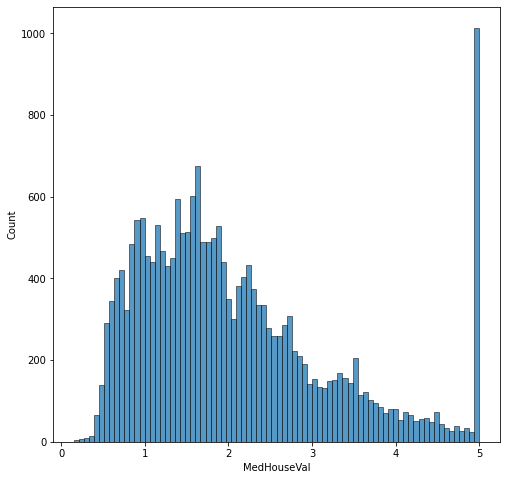

In [121]:
# Гистограмма распределения целевой переменной:

plt.figure(figsize=(8,8))
sns.histplot(y_data, bins=80)
plt.show()

In [122]:
# Обращает на себя внимание большое количество случаев стоимости квартир около 5 (насколько я понял, это 500,000)

In [123]:
# Тренировка и тестирование модели на исходных данных без модификации:

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=20 )
housing_model = LinearRegression()
housing_model.fit(X_train, y_train)

predicted_data = housing_model.predict(X_test)
print('predicted_data: ', predicted_data)

predicted_data_train = housing_model.predict(X_train)
print('predicted_data_train: ', predicted_data_train)

print(housing_model.score(X_train, y_train))
print(housing_model.score(X_test, y_test))

mse_data = mse(y_test, predicted_data)
print(mse_data)
# print(np.sqrt(mse_data))

mse_data_train = mse(y_train, predicted_data_train)
print(mse_data_train)
# print(np.sqrt(mse_data_train))


predicted_data:  [1.70563681 2.93642783 1.70382867 ... 1.85200935 2.81254013 1.09470877]
predicted_data_train:  [1.54922356 1.78209967 2.306524   ... 2.19370178 2.99205608 2.63903909]
0.6229663166510485
0.6306718599959584
0.5151902346190244
0.4960633759757661


In [124]:
# Тренировка и тестирование модели на данных после нормализации минимакс:

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm_data, y_data, test_size=0.2, random_state=20 )

housing_model1 = LinearRegression()
housing_model1.fit(X_train_norm, y_train_norm)

predicted_data_norm = housing_model1.predict(X_test_norm)
print('predicted_data: ', predicted_data_norm)

predicted_data_train_norm = housing_model1.predict(X_train_norm)
print('predicted_data_train: ', predicted_data_train_norm)

print(housing_model1.score(X_train_norm, y_train_norm))
print(housing_model1.score(X_test_norm, y_test_norm))

mse_data1 = mse(y_test_norm, predicted_data_norm)
print(mse_data1)

mse_data_train1 = mse(y_train_norm, predicted_data_train_norm)
print(mse_data_train1)

predicted_data:  [1.58523874 2.99985648 1.76829963 ... 1.75861396 2.82711353 1.17136422]
predicted_data_train:  [1.73595268 1.89357007 2.33837174 ... 2.26286403 3.03120504 2.55513771]
0.6122767957917028
0.6230245253287804
0.5258578001648031
0.510127583072464


In [125]:
# Тренировка и тестирование модели на данных после z-масштабирования:

X_train_z, X_test_z, y_train_z, y_test_z = train_test_split(X_z_data, y_data, test_size=0.2, random_state=20 )
housing_model2 = LinearRegression()

housing_model2 = LinearRegression()
housing_model2.fit(X_train_z, y_train_z)

predicted_data_z = housing_model2.predict(X_test_z)
print('predicted_data: ', predicted_data_z)

predicted_data_train_z = housing_model2.predict(X_train_z)
print('predicted_data_train: ', predicted_data_train_z)

print(housing_model2.score(X_train_z, y_train_z))
print(housing_model2.score(X_test_z, y_test_z))

mse_data2 = mse(y_test_z, predicted_data_z)
print(mse_data2)

mse_data_train2 = mse(y_train_z, predicted_data_train_z)
print(mse_data_train2)

predicted_data:  [1.58523874 2.99985648 1.76829963 ... 1.75861396 2.82711353 1.17136422]
predicted_data_train:  [1.73595268 1.89357007 2.33837174 ... 2.26286403 3.03120504 2.55513771]
0.6122767957917028
0.6230245253287805
0.525857800164803
0.5101275830724639


In [130]:
# После просмотра лекции - очень понравилась библиотека KeplerGl, решил сохранить образец ее использования

# !pip install keplergl

# from keplergl import KeplerGl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
# map_ = KeplerGl(height=700)
# map_.add_data(california_housing, 'Housing')
# map_.save_to_html(file_name='./california_housing.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ./california_housing.html!


Сформулируйте выводы по проделанной работе.
a. Кратко опишите какие преобразования были сделаны с данными.
b. Сравните метрики всех моделей. Желательно оформление в виде таблицы вида |модель|RMSE|R2|признаки, на которых проводилось обучение с указанием их преобразований|.
c. Напишите свое мнение, в полной ли мере модели справились с поставленной задачей.
Для получения зачета по этому домашнему заданию, минимально, должно быть реализовано обучение реализовано обучение трех моделей регрессии: на основе всех неизмененных признаков; на основе признаков, отобранных по значениям корреляций; на основе признаков, отобранных по значениям корреляций и с удалением выбросов в них. Должны быть выведены метрики RMSE, R2 моделей. Желательно добиться улучшения метрик.

Выводы:

1) Были проведены следующие преобразования данных: проверка на наличие выбросов, оценка корреляции различных признаков, нормализация минимакс, z-масштабирование, построение новых признаков на основе эффектов взаимодействия, превращение признака MedInc (median income) в категориальный с использованием pandas.qcut, кластеризация на 25 регионов с использованием геоданных. 

2) Наибольший эффект на эффективность модели (по сравнению с анализом на сырых данных) оказало нахождение новых признаков на основе эффектов взаимодействия - до внедрения новых признаков модель показывала эффективность предсказания в пределах 58-60%, после внедрения новых признаков - 61-62%. Также более 1% добавила кластеризация по геоданным - до 62-63%. Большего увеличения эффективности модели мне добиться не удалось. В литературных данных (в частности в книге Прикладное машинное обучение с помощью
Scikit-Learn и TensorFlow (автор - Орельен Жерон)) и в интернете после данных преобразований этого датасета исследователи переходят от линейной регрессии к более продвинутым алгоритмам машинного обучения (таким, как DecisionTreeRegressor, RandomForestRegressor), чтобы добиться более высоких показателей точности.

3) Я думаю, что для достижения большей прогностической эффективности необходимо в данном случае использовать более сложные модели машинного обучения, т.к. линейная модель недостаточно четко определяет взаимоотношения между имеющимися признаками и целевой переменной.

4) Для данного конкретного датасета на эффективность модели не оказали существенного влияния такие преобразования как Z-масштабирование и нормализация (разница в эффективности предсказания между исходными и преобразованными данными оказалась крайне незначительной).